In [135]:
# %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [136]:
__author__ = 'jcorrea'

# Data dependencies
import h5py
import pickle
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import os
# import ipdb

# E+Y: This might break things since I am appending the module's 
# PYTHONPATH from Edison on the system running the notebooks
import sys
sys.path.append("/project/projectdirs/nervana/jusk/experimental/site-packages/")


(-0.5, 223.5, 157.5, -0.5)

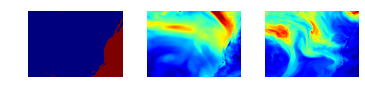

In [137]:
# Land-mask and TMQ data for AR/nAR

basepath = "/project/projectdirs/nervana/jusk/experimental/data"

fland = os.path.join(basepath, "landmask_imgs.pkl")
far = os.path.join(basepath, "atmosphericriver_TMQ.h5")

dland = np.asarray(pickle.load(open(fland, 'r'))['mask'])
darnar = h5py.File(far, 'r')

dar = np.asarray(darnar['AR'])
dnar = np.asarray(darnar['Non_AR'])

%matplotlib inline

# Land-mask, AR, nAR
f = plt.subplots()
plt.subplot(3, 3, 1)
plt.imshow(dland[0])
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(dar[0][0])
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(dnar[0][0])
plt.axis('off')

(-0.5, 223.5, 157.5, -0.5)

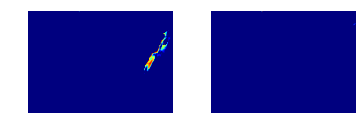

In [138]:
# TMQ thresholding
tmq_thr = 20
dar_i = np.multiply(dar, dland).clip(tmq_thr)
dnar_i = np.multiply(dnar, dland).clip(tmq_thr)

%matplotlib inline
# Thr LM.*AR/LM.*nAR
f = plt.subplots()

# Thresholded AR
plt.subplot(2, 2, 1)
plt.imshow(dar_i[0][0])
plt.axis('off')

# Thresholded nAR
plt.subplot(2, 2, 2)
plt.imshow(dnar_i[0][0])
plt.axis('off')

In [139]:
# TR/TE sizes for AR/nAR

tr_size_ar = 2000
tr_size_nar = 2000

te_size_ar = 468
te_size_nar = 1077

l_ar = np.ones(tr_size_ar + te_size_ar)
l_nar = np.zeros(tr_size_nar + te_size_nar)

s = range(len(dar))
d = range(len(dnar))
np.random.shuffle(s)
np.random.shuffle(d)

tr_ar = np.squeeze(dar[s][:][:][:tr_size_ar])
tr_nar = np.squeeze(dnar[d][:][:][:tr_size_nar])

te_ar = np.squeeze(dar[s][:][:][-te_size_ar:])
te_nar = np.squeeze(dnar[d][:][:][-te_size_nar:])

In [140]:
# d_tr.shape

In [148]:
# Some data manupulation
Ftr_ar = np.asarray([normalize(tr_ar[i]).flatten() for i in range(len(tr_ar))])
Ftr_nar = np.asarray([normalize(tr_nar[i]).flatten() for i in range(len(tr_nar))])
Fte_ar = np.asarray([normalize(te_ar[i]).flatten() for i in range(len(te_ar))])
Fte_nar = np.asarray([normalize(te_nar[i]).flatten() for i in range(len(te_nar))])

d_tr = np.vstack(([Ftr_ar, Ftr_nar]))
d_te = np.vstack(([Fte_ar, Fte_nar]))

l_tr = np.vstack(([[1,0]] * tr_size_ar,
                [[0,1]] * tr_size_nar))

l_te = np.vstack(([[1,0]] * te_size_ar,
                [[0,1]] * te_size_nar))

xx_size = 158
yy_size = 224

In [149]:
# neon dependencies
import logging
import neon
import neon.backends
from neon.backends import gen_backend
# from neon.backends.backend import Backend
from neon.layers import FCLayer, DataLayer, CostLayer
from neon.models import MLP
from neon.transforms import RectLin, Logistic, CrossEntropy
from neon.datasets import MNIST
from neon.experiments import FitPredictErrorExperiment
from neon.datasets.dataset import Dataset

logging.basicConfig(level=20)
logger = logging.getLogger()

# neon model
class AR(Dataset):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        self.data_train = self.data['data_train']
        self.data_test = self.data['data_test']
        self.labels_train = self.data['labels_train']
        self.labels_test = self.data['labels_test']
                
#     def initialize(self):
#         pass
    
    def load(self, backend=None, experiment=None):
        # Dataset.inputs
        
#         self.backend = None
        self.inputs = {'train': self.data_train,
                       'test': self.data_test,
                       'validation': None}

        self.targets = {'train': self.labels_train,
                        'test': self.labels_test,
                        'validation': None}
        
        self.format()
        
def create_model(nin):
    layers = []
    # layers.append(DataLayer(nout=nin[0], name='input'))
    # layers.append(DataLayer(nout=784, name='input'))
    # layers.append(DataLayer(nout=35392, name='input'))
    layers.append(DataLayer(name='d0', ofmshape=[35392, 1], is_local=True, nofm=1))
            # name='d0', ofmshape=[xx_size, yy_size]
        # is_local: True,
        # nofm: 3,
        # ofmshape: [32, 32],
#       },
    layers.append(FCLayer(nout=100, activation=RectLin(), name='h0'))
    layers.append(FCLayer(nout=10, activation=Logistic(), name='h1'))
    layers.append(CostLayer(cost=CrossEntropy(), name='y'))
    # model = MLP(num_epochs=10, batch_size=128, layers=layers)
    model = MLP(num_epochs=10, batch_size=224, layers=layers)
    return model



In [150]:
# def run(*args,**kwargs):
nin = [xx_size, yy_size]
# nin = [yy_size,xx_size]
model = create_model(nin=nin)
backend = gen_backend(rng_seed=0)
# backend = gen_backend()
#         ipdb.set_trace()
#         backend = gen_backend(model=model, gpu=None, nrv=False, datapar=False, modelpar=False,
#                         flexpoint=False, rng_seed=0, numerr_handling=None,
#                         half=False, stochastic_round=0, device_id=None)
#         backend = neon.backends.cpu.CPU(rng_seed=0, seterr_handling = {'all':'warn'})
# dataset = MNIST(repo_path='~/data/')
dataset =  AR(data={'data_train':d_tr,
                    'data_test':d_te,
                    'labels_train':l_tr,
                    'labels_test':l_te})
# dataset =  AR(data_train=d_tr,data_test=d_te,labels_train=l_tr,labels_test=l_te)
#     dataset =  AR(data_train="d_tr")
# experiment = FitPredictErrorExperiment(model=model,
#                                            backend=backend,
#                                            dataset=dataset)

# ipdb.set_trace()
experiment = FitPredictErrorExperiment(model=model, backend=backend, dataset=dataset)

experiment.run()

ValueError: operands could not be broadcast together with shapes (10,224) (2,224) (10,224) 